In [3]:
# Utility imports
import pandas as pd
import re as re
import numpy as np
import json

# Plotting data
import matplotlib.pyplot as plt 
import seaborn as sns

# Preprocessing / Text cleaning
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Models for comparison
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Keras
from keras.preprocessing import sequence
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers import Dropout

# Gridsearch / metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score


In [4]:
# Import data
df = pd.read_csv('data/booksummaries.txt',sep='\t', names = ["Wiki ID", "Freebase ID", "Title", "Author", "Publication Date", "Genres", "Summary" ])

In [5]:
df.head()

,Wiki ID,Freebase ID,Title,Author,Publication Date,Genres,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [6]:
df = df[['Title', 'Genres', 'Summary']]

Extract useful columns in the data into a dataframe 

In [7]:
df.isnull().sum()

Title         0
Genres     3718
Summary       0
dtype: int64

Check for any missing values, we see that there are 3718 in the Genres category

In [8]:
df.dropna(subset=['Genres'], inplace=True)

Drop these rows and check to ensure there are no more missing values

In [9]:
df.isnull().sum()

Title      0
Genres     0
Summary    0
dtype: int64

In [10]:
df.shape

(12841, 3)

In [11]:
df.Genres[0]

'{"/m/016lj8": "Roman \\u00e0 clef", "/m/06nbt": "Satire", "/m/0dwly": "Children\'s literature", "/m/014dfn": "Speculative fiction", "/m/02xlf": "Fiction"}'

There are Freebase ID tags at the beginning of each genre tag, to remove we will use json loads.

In [12]:
type(df.Genres[0])

str

In [13]:
type(json.loads(df['Genres'][0]))

dict

In [14]:
json.loads(df['Genres'][0]).values()

dict_values(['Roman à clef', 'Satire', "Children's literature", 'Speculative fiction', 'Fiction'])

In [15]:
genres = []

for i in df['Genres']: 
  genres.append(list(json.loads(i).values())) 

# Add to 'genres' dataframe  
df['Genres'] = genres

In [16]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

227

Count the number of different genres that exist in our dataframe

In [17]:
all_genres = nltk.FreqDist(all_genres) 

# Create a new dataframe with Unique genres and their counts
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [18]:
all_genres_df.head()

,Genre,Count
0,Roman à clef,29
1,Satire,123
2,Children's literature,2122
3,Speculative fiction,4314
4,Fiction,4747


In [19]:
all_genres_df.sort_values(by='Count', ascending = False)

,Genre,Count
4,Fiction,4747
3,Speculative fiction,4314
5,Science Fiction,2870
10,Novel,2463
12,Fantasy,2413
...,...,...
187,Fable,1
188,Bangsian fantasy,1
189,Space western,1
194,Fantastique,1


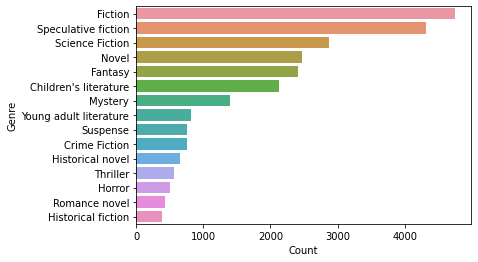

In [20]:
g = all_genres_df.nlargest(columns="Count", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
plt.show()

Plot the frequency distribution of every genre

In [21]:
all_genres_df = all_genres_df.to_dict()

In [22]:
low_freq = []
for i in range(len(all_genres_df['Count'])):
    if all_genres_df['Count'][i] <= 50:
        low_freq.append(all_genres_df['Genre'][i])

In [23]:
len(low_freq)

189

In [24]:
df = df.reset_index(drop=True)

In [25]:
df.head()

,Title,Genres,Summary
0,Animal Farm,"[Roman à clef, Satire, Children's literature, ...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
2,The Plague,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
3,A Fire Upon the Deep,"[Hard science fiction, Science Fiction, Specul...",The novel posits that space around the Milky ...
4,All Quiet on the Western Front,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge..."


In [26]:
index_delete = []
for word in low_freq:
    for i in range(len(df.Genres)):
        if word in df.Genres[i]:
            if i not in index_delete:
                index_delete.append(i)        

In [27]:
df.drop(index_delete , inplace=True)

In [28]:
df.shape

(11283, 3)

Remove genres that contain less than 50 books

In [29]:
df.head()

,Title,Genres,Summary
1,A Clockwork Orange,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
6,Blade Runner 3: Replicant Night,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul..."
7,Blade Runner 2: The Edge of Human,"[Science Fiction, Speculative fiction]",Beginning several months after the events in ...
9,Crash,"[Speculative fiction, Fiction, Novel]",The story is told through the eyes of narrato...
10,Children of Dune,"[Science Fiction, Speculative fiction, Childre...",Nine years after Emperor Paul Muad'dib walked...


In [30]:
df = df.reset_index(drop=True)

In [31]:
# Create new list for genres
genres = []

# Extract genres
for i in range(len(df['Genres'])): 
  genres.append(df['Genres'][i]) 

In [32]:
# Get all genre tags in a list

all_genres = sum(genres,[])
len(set(all_genres))

38

New number of unique genres

In [33]:
print(set(all_genres))

{'Adventure novel', 'Detective fiction', 'Non-fiction', 'Fantasy', 'Science Fiction', 'Horror', 'Thriller', 'Alternate history', 'Comic novel', 'Comedy', 'Apocalyptic and post-apocalyptic fiction', 'Young adult literature', 'Biography', 'Mystery', 'Memoir', 'Autobiographical novel', 'Romance novel', 'Crime Fiction', 'Gothic fiction', 'Speculative fiction', 'Autobiography', 'Satire', 'Fiction', 'High fantasy', "Children's literature", 'Novel', 'Utopian and dystopian fiction', 'War novel', 'Novella', 'History', 'Historical novel', 'Suspense', 'Historical fiction', 'Techno-thriller', 'Spy fiction', 'Humour', 'Dystopia', 'Short story'}


In [34]:
fiction_sub = ['Spy fiction', 'Gothic fiction', 'Historical fiction', 'Detective fiction', 'Utopian and dystopian fiction', 'Speculative fiction']
len(fiction_sub)

6

In [35]:
def clean_fiction(Genres):
    for i in Genres:
        if i in fiction_sub:
            if 'Fantasy' not in Genres:
                Genres.append('Fantasy')
                Genres.remove(i)
            else:
                Genres.remove(i)
    return Genres
    

In [36]:
df['Genres'] = df['Genres'].apply(lambda x: clean_fiction(x))
df['Genres'] = df['Genres'].apply(lambda x: clean_fiction(x))

Combine some fiction subgenres with 'Fiction' (Except some large sub genres such as Science Fiction).

In [37]:
df.Genres

0        [Science Fiction, Novella, Satire, Fiction, Fa...
1                               [Science Fiction, Fantasy]
2                               [Science Fiction, Fantasy]
3                                [Fiction, Novel, Fantasy]
4        [Science Fiction, Children's literature, Ficti...
                               ...                        
11278                    [Young adult literature, Fantasy]
11279                                    [Science Fiction]
11280                        [Thriller, Fiction, Suspense]
11281                                  [Thriller, Fiction]
11282                                      [Autobiography]
Name: Genres, Length: 11283, dtype: object

In [38]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [39]:
all_genres_df.head()

,Genre,Count
0,Science Fiction,2615
1,Novella,73
2,Speculative fiction,3893
3,Utopian and dystopian fiction,52
4,Satire,82


In [40]:
all_genres_df = all_genres_df.sort_values(by='Count', ascending = False)
all_genres_df = all_genres_df.reset_index(drop=True)
all_genres_df.head()

,Genre,Count
0,Fiction,4191
1,Speculative fiction,3893
2,Science Fiction,2615
3,Novel,2263
4,Fantasy,2176


New frequency distribution of genres

In [41]:
df.Summary[0][:300]

' Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random "ultra-violence." Alex\'s friends ("droogs" in the novel\'s Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang\'s muscle; Georgie, an ambitious second-in-command; and Pet'

In [42]:
def clean_text(text):
    
    # change all letters to lower case
    text = text.lower()
    
    # remove all numbers from text
    text = re.sub(r'\d+', '', text)
    
    # remove all white spaces from text
    text = text.strip()
    
    # remove all punctuation from text
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

In [43]:
df['Summary'] = df['Summary'].apply(lambda x: clean_text(x))

In [44]:
df.Summary[0][:300]

'alex a teenager living in nearfuture england leads his gang on nightly orgies of opportunistic random ultraviolence alexs friends droogs in the novels anglorussian slang nadsat are dim a slowwitted bruiser who is the gangs muscle georgie an ambitious secondincommand and pete who mostly plays along a'

Begin cleaning text

In [45]:
word_freq = df.Summary.str.split(expand=True).stack().value_counts().rename_axis('Word').reset_index(name='Frequency')

In [46]:
word_freq.head()

,Word,Frequency
0,the,341480
1,to,173240
2,and,165964
3,of,133069
4,a,127906


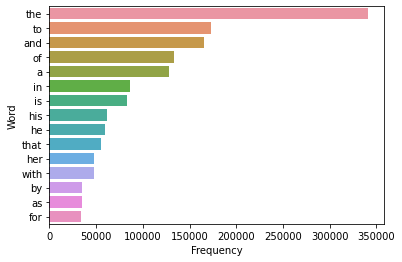

In [47]:
g = word_freq.nlargest(columns="Frequency", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Frequency", y = "Word") 
ax.set(ylabel = 'Word') 
plt.show()

By plotting the most frequent words, we observe that many of them are not useful for classifying genres

In [48]:
def remove_stopwords(text):
    # cache stopwords to run faster
    cachedStopWords = stopwords.words("english")   
    
    text_tokens = word_tokenize(text)
    
    # remove all stopwords
    text = [word for word in text_tokens if word not in cachedStopWords]
    
    # remove words with less than 3 characters
    text = [word for word in text if len(word) >= 3]
    text = ' '.join(text)
    
    return text

df['Summary'] = df['Summary'].apply(lambda x: remove_stopwords(x))

To resolve this, we will remove stopwords using nltk's library and also remove any words with less than 3 characters

In [49]:
df.Summary[0][:300]

'alex teenager living nearfuture england leads gang nightly orgies opportunistic random ultraviolence alexs friends droogs novels anglorussian slang nadsat dim slowwitted bruiser gangs muscle georgie ambitious secondincommand pete mostly plays along droogs indulge taste ultraviolence characterized so'

In [50]:
new_word_freq = df.Summary.str.split(expand=True).stack().value_counts().rename_axis('Word').reset_index(name='Frequency')

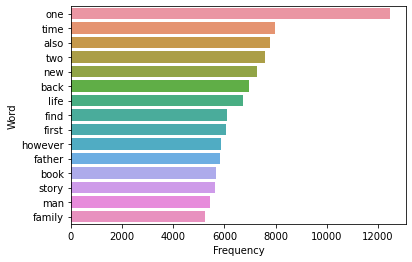

In [51]:
g = new_word_freq.nlargest(columns="Frequency", n = 15) 
plt.figure() 
ax = sns.barplot(data=g, x= "Frequency", y = "Word") 
ax.set(ylabel = 'Word') 
plt.show()

After doing so, the new word frequency distribution looks much better

In [52]:
df.to_csv('data/clean_data.csv', index = False)

In [53]:
new_word_freq.shape

(119882, 2)

In [54]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['Genres'])
y = multilabel_binarizer.transform(df['Genres'])

To prepare our genres for classification, we must encode them using a multilabel binarizer

In [55]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [56]:
all_genres_df['Count'][0]/len(df.Genres) # No. Fiction books / All books

0.3714437649561287

For a baseline comparison, I will compare our models to simply guessing the most frequent genre which is Fiction. If we were to predict fiction for every book, it would achieve a 37% success rate.

In [57]:
x_train, x_test, y_train, y_test = train_test_split(df['Summary'], y, test_size=0.2, random_state=1)

Split the data into training/test data. I have used a 80-20 test/train split.

In [58]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
x_train_vec = tfidf_vectorizer.fit_transform(x_train).astype('float32')
x_test_vec = tfidf_vectorizer.transform(x_test).astype('float32')

In [62]:
rd = RandomForestClassifier()
rd.fit(x_train_vec, y_train)

y_pred = rd.predict(x_test_vec)
print('f1 score (RD): ', f1_score(y_test, y_pred, average="micro"))

f1 score (RD):  0.3319959879638917


To use our summaries as features, We must encode them into vectors. We will use use sklearn's tfidf vectorizer with a max threshhold of 0.8 and using only 10000 max features.

In [57]:
rd = RandomForestClassifier()
clf = OneVsRestClassifier(rd)

clf.fit(x_train_vec, y_train)
y_pred = clf.predict(x_test_vec)

print('f1 score (RD): ', f1_score(y_test, y_pred, average="micro"))

f1 score (RD):  0.38312718046305105


For the first comparison, We will use a OneVsRest Random forest classifier. For these model comparisons, accuracy is not an optimal metric since we have multiple labels so we will be using their f1 scores instead.

In [58]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# Fit model on train data
clf.fit(x_train_vec, y_train)

# make predictions for test set
y_pred = clf.predict(x_test_vec)

print('f1 score (LR): ',f1_score(y_test, y_pred, average = 'micro'))

f1 score (LR):  0.4353906962602615


The OneVsRest Logic regression classifier is slightly better

In [64]:
tk = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tk.fit_on_texts(x_train)

x_train_new = tk.texts_to_sequences(x_train)
x_test_new = tk.texts_to_sequences(x_test)

To prepare our text data for the neural network, we must tokenize the words and create a word index using keras's tokenizer.

In [65]:
for x in list(tk.word_index)[0:5]:
    print ("{}, {} ".format(x,  tk.word_index[x]))

one, 1 
time, 2 
also, 3 
two, 4 
new, 5 


First 5 words of the index, the most frequent words appear first

In [66]:
x_train_new = sequence.pad_sequences(x_train_new, maxlen= 500, padding='pre')
x_test_new = sequence.pad_sequences(x_test_new, maxlen= 500, padding='pre')

Pad the inputs to a maximum length of 500 characters

In [67]:
max_features = len(tk.word_index) + 1

In [104]:
def build_model():
    model = Sequential()
    model.add(Embedding(max_features, 32, input_length=500))
    model.add(Flatten())
    model.add(Dense(60, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(32, activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [105]:
model = build_model()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           3374624   
_________________________________________________________________
flatten_6 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 60)                960060    
_________________________________________________________________
dense_17 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1952      
Total params: 4,340,296
Trainable params: 4,340,296
Non-trainable params: 0
_________________________________________________________________
None


/// GRIDSEARCH for tuning neural network (specifically for finding optimal batch size and epoch count). I only used 4000 samples for this with 2 cross validation folds because my computer is unable to process more. ///

In [124]:
x_train_g = x_train_new[:1000]
y_train_g = y_train[:1000]

model2 = KerasClassifier(build_fn=build_model, verbose=0)
batch_size = [25, 30, 50]
epochs = [2, 3, 4, 6]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(x_train_g[:800], y_train_g[:800], validation_data=(x_train_g[800:], y_train_g[800:]))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 32)           3374624   
_________________________________________________________________
flatten_9 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 60)                960060    
_________________________________________________________________
dense_26 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                1952      
Total params: 4,340,296
Trainable params: 4,340,296
Non-trainable params: 0
_________________________________________________________________
None
Best: 0.934375 using {'batch_size': 25, 'epochs': 2}
0.934375 (0.001328) with: {'batch_size': 25, 'epochs

In [115]:
final_model = model.fit(x_train_new, y_train, validation_data=(x_test_new, y_test), epochs=2, batch_size= 25)

Train on 9026 samples, validate on 2257 samples
Epoch 1/2
9026/9026 [==============================] - 11s 1ms/step - loss: 0.1393 - accuracy: 0.9436 - val_loss: 0.1692 - val_accuracy: 0.9386
Epoch 2/2
9026/9026 [==============================] - 11s 1ms/step - loss: 0.1117 - accuracy: 0.9519 - val_loss: 0.1726 - val_accuracy: 0.9404


Build and fit model

[]

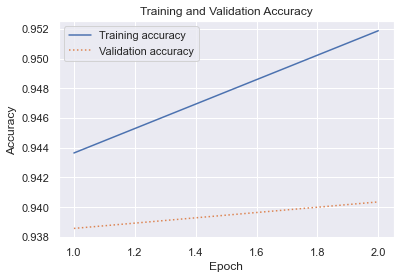

In [116]:
sns.set()
acc = final_model.history['accuracy']
val = final_model.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

Visualize the training/validation accuracy over epochs 

In [117]:
out = model.predict(x_test_new)

In [118]:
out.shape

(2257, 32)

In [119]:
out[0]

array([4.0026163e-04, 1.2298347e-03, 9.9556491e-05, 5.3847111e-07,
       7.0921267e-08, 1.5104915e-07, 8.6530879e-02, 1.9717892e-04,
       1.1364564e-05, 2.7213775e-07, 1.3968184e-04, 3.0660883e-01,
       1.4889547e-01, 1.6266742e-04, 5.3725421e-04, 4.5451338e-06,
       2.2108015e-03, 1.0914737e-05, 8.6053880e-08, 5.4530141e-05,
       7.7073015e-09, 2.0658856e-03, 1.1214673e-05, 6.0017945e-05,
       2.1753111e-05, 4.4927585e-01, 8.9868099e-06, 4.4862158e-05,
       1.4285324e-04, 2.0066746e-04, 6.1233447e-07, 1.0724365e-03],
      dtype=float32)

In [120]:
out = np.array(out)
y_pred = np.zeros(out.shape)
y_pred[out>0.2]=1
y_pred = np.array(y_pred)

In [121]:
print("f1 score (NN): ", f1_score(y_pred,y_test, average = 'micro'))

f1 score (NN):  0.4595744680851064


Using a neural network results in a higher f1 score than the previous two models

In [122]:
scores = model.evaluate(x_test_new, y_test, verbose=0)
print("Accuracy (NN): %.2f%%" % (scores[1] * 100))

Accuracy (NN): 94.04%


Accuracy score

In [74]:
multilabel_binarizer.inverse_transform(y_pred)[10]

("Children's literature",
 'Crime Fiction',
 'Fantasy',
 'Fiction',
 'Mystery',
 'Novel',
 'Suspense')

In [75]:
multilabel_binarizer.inverse_transform(y_test)[10]

('Crime Fiction', 'Fantasy', 'Mystery', 'Suspense')

Output prediction/actual genre for a random test

In [76]:
title_list = df.Title.to_list()

Prepare a list of all titles in our dataset for use in our inference function

In [78]:
with open('data/titles.txt', 'w') as f:
    for title in title_list:
        f.write("%s\n" % title)

In [79]:
def inference_predict(title):
    # If title is not in dataframe
    if title not in title_list:
        print('Title not found.')
        return
    index = title_list.index(title)
    actual_genre = df.Genres[index]
    p_summary = [df.Summary[index]]
    
    convert = tk.texts_to_sequences(p_summary)
    convert = sequence.pad_sequences(convert, maxlen= 500, padding='pre')
    #print(convert[0])
    
    output = model.predict(convert)
    output = np.array(output)
    #print(output.shape)
    prediction = np.zeros(output.shape)
    prediction[output>0.2]=1
    prediction = np.array(prediction)
    
    print('Title: ', title)
    print('Predicted Genres: ', multilabel_binarizer.inverse_transform(prediction)[0])
    print('Actual Genres: ', actual_genre)

The inference function takes a book title name as an input and searches our title list to see if it exists in the dataframe. If it exists, it will extract the already cleaned summary and make a prediciton out of it which we can then compare to the actual genres.

In [80]:
inference_predict("Ender's Game")

Title:  Ender's Game
Predicted Genres:  ('Fantasy', 'Fiction', 'Science Fiction')
Actual Genres:  ['Science Fiction', 'Fiction', 'Fantasy']


In [81]:
inference_predict("Clockwork Angel")

Title:  Clockwork Angel
Predicted Genres:  ("Children's literature", 'Fantasy', 'Historical novel', 'Novel', 'Romance novel', 'Young adult literature')
Actual Genres:  ['Fantasy', 'Young adult literature', 'Romance novel']


In [82]:
inference_predict("Dead Air")

Title:  Dead Air
Predicted Genres:  ('Fiction', 'Mystery', 'Novel')
Actual Genres:  ['Fiction', 'Novel']


In [83]:
inference_predict("Spartan")

Title:  Spartan
Predicted Genres:  ('Fantasy', 'Novel')
Actual Genres:  ['Historical novel']


In [84]:
word_index = [word for word in tk.word_index]

In [85]:
def analyse(text):
    # Clean input text
    text = clean_text(text)
    text = remove_stopwords(text)  
    text = text.split()

    # Convert text for Neural network
    text = [word for word in text if word in word_index]
    text = [' '.join(text)]
    convert = tk.texts_to_sequences(text)
    convert = sequence.pad_sequences(convert, maxlen= 500, padding='pre')

    # Make prediction
    output = model.predict(convert)
    output = np.array(output)
    prediction = np.zeros(output.shape)
    prediction[output>0.2]=1
    prediction = np.array(prediction)
    
    #print('Clean input: ', text)
    print('Predicted Genres: ', multilabel_binarizer.inverse_transform(prediction)[0]) 

This function takes in our own summary input to predict genres. To test this I have copied a plot summary of 'Woman in White' from Wikipedia and saved it to a file for input. 

In [86]:
print('Woman in white in data? ', 'The Woman in White' in title_list)
with open('data/WIM_plot.txt', 'r') as file:
    summary1 = file.read().replace('\n', '')
    analyse(summary1)

Woman in white in data?  False
Predicted Genres:  ('Fiction', 'Mystery', 'Novel')


First we check if our custom input book does not exist in the dataframe, then we will predict It's genres. The actual genres for this book are Novel, Fiction, Gothic and Mystery so we can say this prediction is considerably accurate.